# HBC 722 SED Preparation

This notebook reads in spectral data and resamples it to prepare for MCMC fitting of the SED. Started 8 August 2019.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate
import emcee
import corner
from fu_ori_functions_new import *
from fu_ori_classes_new import *
%matplotlib inline 
from PyAstronomy import pyasl

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Class environment

In [3]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
#         print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
#         print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_SED,self.wave_upper_SED, \
                            binning=10, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    def createFUOriBB(self, r_star, r_outer, m_star, m_dot, inc, a_v,  dist, grav, direc):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 0.1*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliBlackbody(np.arange(self.wave_lower_SED, self.wave_upper_SED, 10))
#         print('Preparing annuli for broadening and summing...')
#         fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
#                             binning=1, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('blackbodies', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, redden):
            return self.fuori.viewModelSpectrum(wave_lower, wave_upper, False, redden)
    def getModSpecPoint(self, wave, redden):
        return np.mean(self.viewModelSpectrum(wave-10, wave+10, redden)[1])

### Making an instance of the class

In [6]:
M_STAR = 0.56*M_SUN
R_STAR= 1.39*R_SUN
R_OUTER = 80 * R_STAR
M_DOT = 10**(-5.41) * M_SUN / 3.154e7

A_V = 3.16
INC = 30.
DIST = 795*3.08567758128e18
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/'

In [7]:
gaia17bpi_env = FUOriEnvironment(3.5e3, 50e3)
gaia17bpi_envbb = FUOriEnvironment(3.5e3, 50e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC,  a_v=A_V,dist = DIST, grav = 1.5, direc = DIREC)
%time modSpec = gaia17bpi_env.viewModelSpectrum(3e3, 5e4, True)

%time gaia17bpi_envbb.createFUOriBB(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC,   a_v=A_V,dist = DIST, grav = 1.5, direc = DIREC, a_v=A_V)
%time modSpecbb = gaia17bpi_envbb.viewModelSpectrum(3e3, 5e4, True)

Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6800.
Used stellar atmosphere at T = 6600.
Used stellar atmosphere at T = 6400.
Used stellar atmosphere at T = 6200.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3800.
Used stellar atmosphere at T = 3600.
Used stellar atmosphere at T = 3400.
Used stellar atmosphere at T = 3200.
Used stellar atmosphere at T = 3000.
Used stellar atmosphere at T = 2800.
Used stellar atmosphere at T = 2600.
Used stellar atmosphere at T = 2400.
Used stellar atmosphere at T = 2200.
Used stellar atmosphere at T = 2000.
No stellar atmosphere for annulus of T

SyntaxError: keyword argument repeated (<unknown>, line 1)

## Reading in Palomar data

In [258]:
def cleanPointsAndSplit(waves, lums, regions_good):
    waves_final, lums_final = [], []
    for i in range(len(regions_good)):
        start, end = regions_good[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        
        waves_final.append(waves[ind_lower:ind_upper])
        lums_final.append(lums[ind_lower:ind_upper])
    waves_new, fluxes_new = [], []
    waves_bad = np.concatenate(waves_final)
    for i in range(len(waves)):
        wave_pt = waves[i]
        if not np.isin(wave_pt, waves_bad):
            waves_new.append(wave_pt)
            fluxes_new.append(lums[i])
            
                           
    return np.array(waves_new), np.array(fluxes_new)

In [259]:
PATH = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Data/HBC 722/'

def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [260]:
newtxt = getDataArray(PATH + 'hbc722_blue.txt')

wavesDATA_OPT = newtxt[:,0] 
fluxesDATA_OPT = newtxt[:,1]

newtxt2 = getDataArray(PATH + 'hbc722_red.txt')

wavesDATA_OPT2 = newtxt2[:,0][10:]
fluxesDATA_OPT2 = newtxt2[:,1][10:]

newtxt_new = getDataArray(PATH + 'hbctxt_new')

wavesDATA_OPT_NEW = newtxt_new[:,0][10:]
fluxesDATA_OPT_NEW = newtxt_new[:,1][10:]

In [261]:
WAV_SCALE

array([3853.78618702, 3854.8647071 , 3855.94322718, ..., 6821.87344061,
       6822.95196069, 6824.03048076])

In [262]:
WAV_SCALE, VAL_SCALE = getDataArray('flux_calibrator.csv')[:,0], getDataArray('flux_calibrator.csv')[:,1]

In [263]:
REGIONS_OPT = np.array([(2e3, 3.87e3), (4.855e3, 4.865e3), (5.884e3, 5.900e3), (6.555e3, 6.585e3), \
                        (6.455e3, 6.505e3), (6.610e3, 7e33)])

REGIONS_OPT_NEW = np.array([(1e3, 3.55e3), (4.855e3, 4.865e3), (5.884e3, 5.900e3), (6.555e3, 6.585e3), \
                        (6.455e3, 6.505e3),(6.450e3, 6.57e3),(7.2e3, 7.78e3), (8.1e3, 8.5e3), (8.490e3, 8.505e3), (8.535e3, 8.555e3),\
                         (8.655e3, 8.665e3), (8.9e3, 9.7e3), (9.9e3, 11e3)])

In [264]:
wavesDATA_OPT_CLEAN, fluxesDATA_OPT_CLEAN = cleanPointsAndSplit(wavesDATA_OPT, fluxesDATA_OPT, REGIONS_OPT)

wavesDATA_OPT_NEW_CLEAN, fluxesDATA_OPT_NEW_CLEAN = cleanPointsAndSplit(wavesDATA_OPT_NEW, fluxesDATA_OPT_NEW, REGIONS_OPT_NEW)

In [265]:
interp_func = interpolate.interp1d(WAV_SCALE, VAL_SCALE)
correction = interp_func(wavesDATA_OPT_CLEAN)

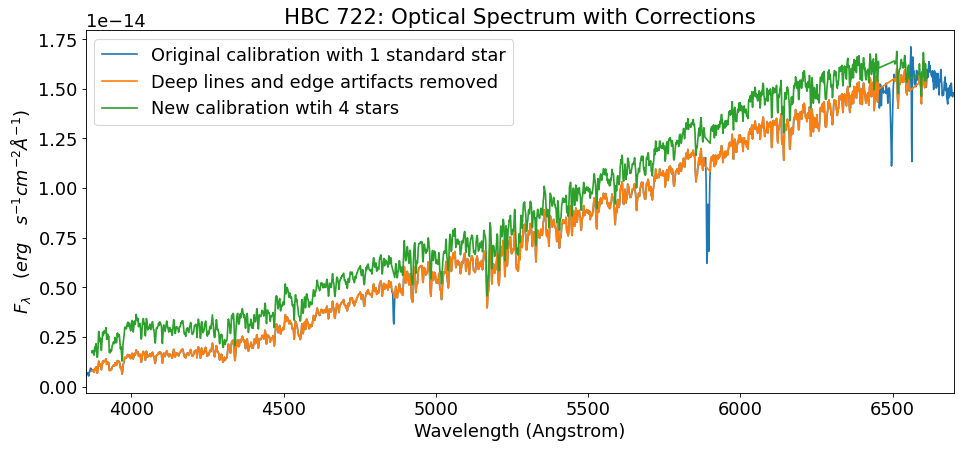

In [266]:
fig=plt.figure(figsize=(14, 6), dpi= 80)
plt.rcParams.update({'font.size': 16})

plt.plot(wavesDATA_OPT, fluxesDATA_OPT, label='Original calibration with 1 standard star')

plt.plot(wavesDATA_OPT_CLEAN, fluxesDATA_OPT_CLEAN, label='Deep lines and edge artifacts removed')
plt.plot(wavesDATA_OPT_CLEAN, fluxesDATA_OPT_CLEAN*correction, label='New calibration wtih 4 stars')

# plt.plot(wavesDATA_OPT_NEW, fluxesDATA_OPT_NEW)
# plt.plot(wavesDATA_OPT_NEW_CLEAN, fluxesDATA_OPT_NEW_CLEAN, label='Lick data')
plt.ylabel(r'$F_\lambda \quad(erg\quad s^{-1} cm^{-2} \AA^{-1})$')
plt.xlim(3850, 6700)
plt.xlabel('Wavelength (Angstrom)')
plt.legend()
plt.title('HBC 722: Optical Spectrum with Corrections')
# plt.savefig("spectrum_corrections.png", dpi=200, bbox_inches='tight')

plt.show()


In [267]:
waves_NEW1 = wavesDATA_OPT_NEW_CLEAN[:3403]
waves_NEW2 = wavesDATA_OPT_NEW_CLEAN[3403:3714]
waves_NEW3 = wavesDATA_OPT_NEW_CLEAN[3714:4066]
waves_NEW4 = wavesDATA_OPT_NEW_CLEAN[4066:]

In [268]:
fluxes_NEW1 = fluxesDATA_OPT_NEW_CLEAN[:3403]
fluxes_NEW2 = fluxesDATA_OPT_NEW_CLEAN[3403:3714]
fluxes_NEW3 = fluxesDATA_OPT_NEW_CLEAN[3714:4066]
fluxes_NEW4 = fluxesDATA_OPT_NEW_CLEAN[4066:]

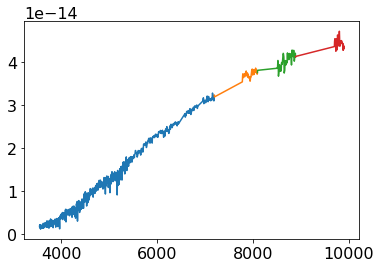

In [269]:
plt.plot(waves_NEW1, fluxes_NEW1)
plt.plot(waves_NEW2, fluxes_NEW2)
plt.plot(waves_NEW3, fluxes_NEW3)
plt.plot(waves_NEW4, fluxes_NEW4)

In [270]:
REGIONS_OPT2 = np.array([(7.2e3, 7.74e3), (8.1e3, 8.4e3), (8.490e3, 8.505e3), (8.535e3, 8.555e3),\
                         (8.655e3, 8.665e3), (8.9e3, 9.2e33)])
wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN = cleanPointsAndSplit(wavesDATA_OPT2, fluxesDATA_OPT2, REGIONS_OPT2)


In [271]:
SPLIT_POINT = np.searchsorted(wavesDATA_OPT2_CLEAN, 8200)

In [272]:
SPLIT_POINT

906

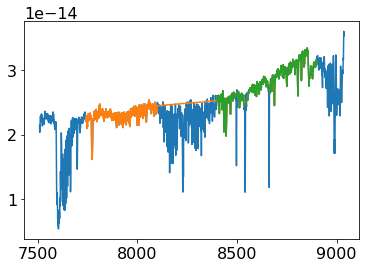

In [273]:
plt.plot(wavesDATA_OPT2, fluxesDATA_OPT2)
wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN = cleanPointsAndSplit(wavesDATA_OPT2, fluxesDATA_OPT2, REGIONS_OPT2)
plt.plot(wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN)
plt.plot(wavesDATA_OPT2_CLEAN[SPLIT_POINT:], fluxesDATA_OPT2_CLEAN[SPLIT_POINT:])

## Reading infrared data

In [274]:
newtxt3 = getDataArray(PATH + 'PTF10qpf.y.txt')

wavesDATA_INF1 = newtxt3[:,0][10:]*1e4
fluxesDATA_INF1 = newtxt3[:,1][10:]/16

newtxt4 = getDataArray(PATH + 'PTF10qpf.j.txt')

wavesDATA_INF2 = newtxt4[:,0][10:]*1e4
fluxesDATA_INF2 = newtxt4[:,1][10:]/16

newtxt5 = getDataArray(PATH + 'PTF10qpf.h.txt')

wavesDATA_INF3 = newtxt5[:,0][10:]*1e4
fluxesDATA_INF3 = newtxt5[:,1][10:]/16

newtxt6 = getDataArray(PATH + 'PTF10qpf.k.txt')

wavesDATA_INF4 = newtxt6[:,0][10:]*1e4
fluxesDATA_INF4 = newtxt6[:,1][10:]/16


In [275]:
def getDataArrayK(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(250, len(fulltxt)):
        line = fulltxt[i]
        if len(line) > 2:
            line = fulltxt[i][:-1]
  
            line = line.split()
            line = [line[0], line[1]]
            newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [276]:
import os
from specutils import Spectrum1D

file_path = os.path.join(PATH, 'hbc_new_nir_1.fits')

spec = Spectrum1D.read(file_path, format='wcs1d-fits')

In [277]:
newtxt_kospal1 = getDataArrayK(PATH + 'kospal_hbc722_20110721_zj_tellcorr.txt')
wav_x1, flux_x1 = newtxt_kospal1[:,0], newtxt_kospal1[:,1]

newtxt_kospal2 = getDataArrayK(PATH + 'kospal_hbc722_20110721_hk_tellcorr.txt')
wav_x2, flux_x2 = newtxt_kospal2[:,0], newtxt_kospal2[:,1]

In [278]:
10**((11.5-11.25)/2.5)

1.2589254117941673

In [279]:
wavesDATA_INF_K = np.concatenate((wav_x1, wav_x2))
fluxesDATA_INF_K = np.concatenate((2.5*flux_x1, 2.5*flux_x2))

In [280]:
wav_x2

array([14089.07910156, 14098.71159077, 14108.34407997, ...,
       23923.85057926, 23933.48306847, 23943.11555767])

In [281]:
wavesDATA_INF_K

array([ 8951.5625    ,  8957.62297535,  8963.6834507 , ...,
       23923.85057926, 23933.48306847, 23943.11555767])

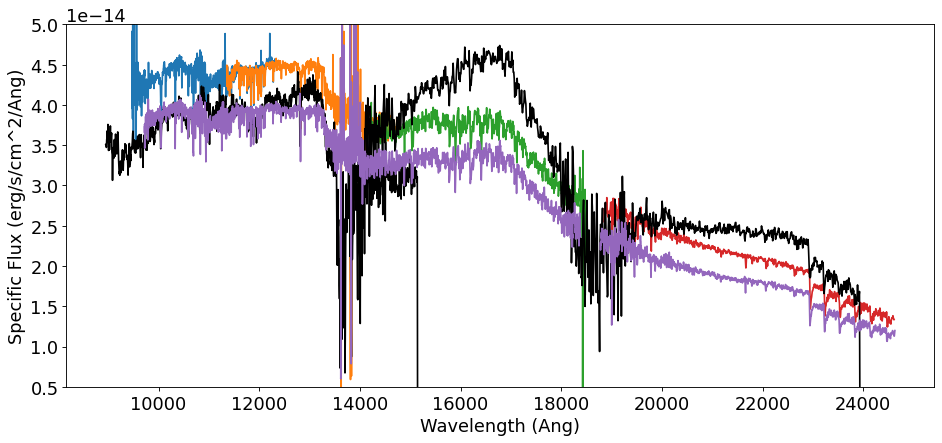

In [282]:
fig=plt.figure(figsize=(14, 6), dpi= 80)
plt.plot(wavesDATA_INF1, fluxesDATA_INF1)
plt.plot(wavesDATA_INF2, fluxesDATA_INF2)
plt.plot(wavesDATA_INF3, fluxesDATA_INF3)
plt.plot(wavesDATA_INF4, fluxesDATA_INF4)
plt.plot(wav_x1, 2.5*flux_x1, 'k')
plt.plot(wav_x2, 2.5*flux_x2, 'k')
plt.plot(spec.flux[0]*1e4, spec.flux[1])

plt.xlabel('Wavelength (Ang)')
plt.ylabel('Specific Flux (erg/s/cm^2/Ang)')
plt.ylim(0.5e-14, 5e-14)
plt.show()

In [555]:
REGIONS = np.array([(1e3, 9.8e3),  (13.0e3, 14.7e3), (18.0e3, 19.5e3)])


In [556]:
wavesDATA_INF_K, fluxesDATA_INF_K

(array([ 8951.5625    ,  8957.62297535,  8963.6834507 , ...,
        23923.85057926, 23933.48306847, 23943.11555767]),
 array([3.5087575e-14, 3.5051600e-14, 3.4719525e-14, ..., 1.6837425e-14,
        0.0000000e+00, 0.0000000e+00]))

In [557]:
wavesDATA_INFX, fluxesDATA_INFX = cleanPointsAndSplit(wavesDATA_INF_K, fluxesDATA_INF_K, REGIONS)

In [558]:
# wavesDATA_INF1, fluxesDATA_INF1 = cleanPointsAndSplit(wavesDATA_INF1, fluxesDATA_INF1, REGIONS)
# wavesDATA_INF2, fluxesDATA_INF2 = cleanPointsAndSplit(wavesDATA_INF2, fluxesDATA_INF2, REGIONS)
# wavesDATA_INF3, fluxesDATA_INF3 = cleanPointsAndSplit(wavesDATA_INF3, fluxesDATA_INF3, REGIONS)
# wavesDATA_INF4, fluxesDATA_INF4 = cleanPointsAndSplit(wavesDATA_INF4, fluxesDATA_INF4, REGIONS)

In [559]:
indx_J = np.argwhere(wavesDATA_INFX < 14000)
indx_K = np.argwhere(wavesDATA_INFX > 19000)
indx_H = np.arange(max(indx_J)+1, min(indx_K), 1)

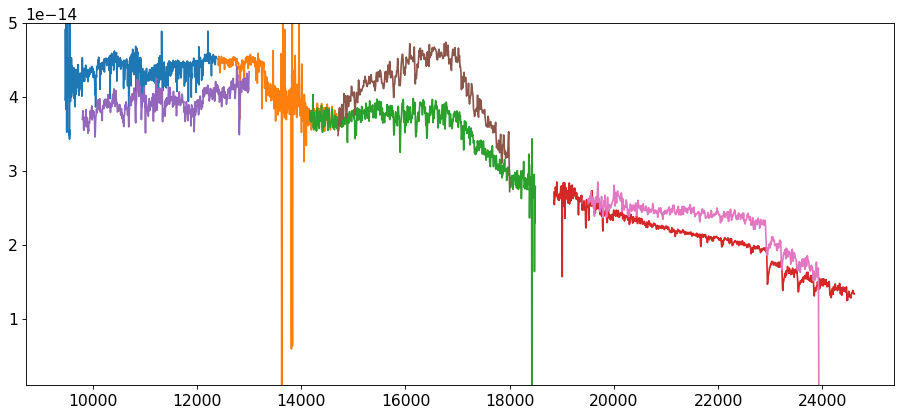

In [560]:
fig=plt.figure(figsize=(14, 6), dpi= 80)
plt.plot(wavesDATA_INF1, fluxesDATA_INF1)
plt.plot(wavesDATA_INF2, fluxesDATA_INF2)
plt.plot(wavesDATA_INF3, fluxesDATA_INF3)
plt.plot(wavesDATA_INF4, fluxesDATA_INF4)

plt.plot(wavesDATA_INFX[indx_J], fluxesDATA_INFX[indx_J])
plt.plot(wavesDATA_INFX[indx_H], fluxesDATA_INFX[indx_H])
plt.plot(wavesDATA_INFX[indx_K], fluxesDATA_INFX[indx_K])








plt.ylim(1e-15, 5e-14)
plt.show()

In [561]:
# waves_INF_LIST = [wavesDATA_INF1, wavesDATA_INF2, wavesDATA_INF3, wavesDATA_INF4]
# fluxes_INF_LIST = [fluxesDATA_INF1, fluxesDATA_INF2,\
#                    fluxesDATA_INF3, fluxesDATA_INF4]

waves_INF_LIST = [list(wavesDATA_INFX[indx_J]), list(wavesDATA_INFX[indx_H]), list(wavesDATA_INFX[indx_K])]
fluxes_INF_LIST = [list(fluxesDATA_INFX[indx_J]), list(fluxesDATA_INFX[indx_H]), list(fluxesDATA_INFX[indx_K])]

In [562]:
wav, lum = modSpec

In [563]:
x_atm = np.log10(wav*1e-4)
y_atm = np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))


### Reddening data

In [564]:
from PyAstronomy import pyasl

In [565]:
x_red, y_red = makeExtinctionCurve(wavesDATA_OPT_NEW_CLEAN, 3.1)

In [566]:
a_lambda = 1.2*y_red

In [567]:
wNEW, fNEW = wavesDATA_OPT_NEW_CLEAN, fluxesDATA_OPT_NEW_CLEAN

In [568]:
flux_corrected = pyasl.unred(wNEW, fNEW, -0.5/3.1)

### Plotting data with model

In [569]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


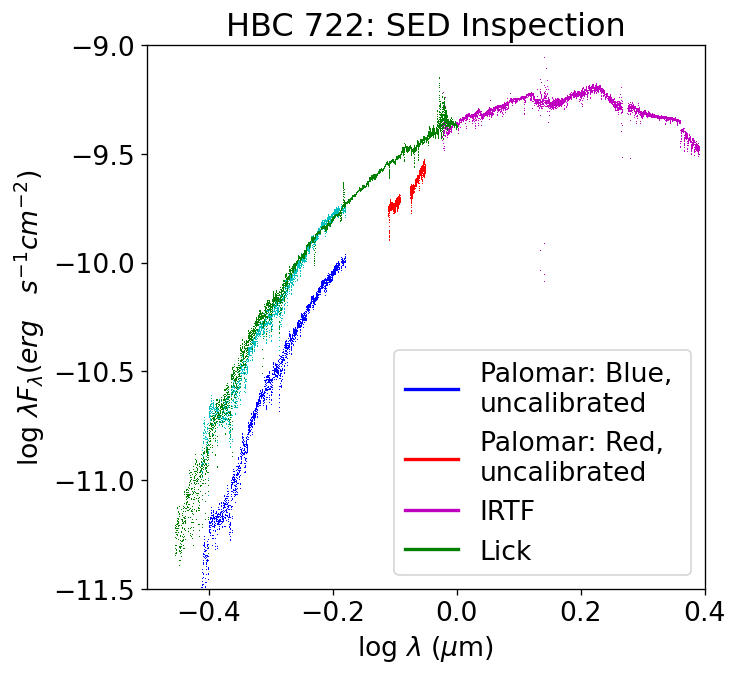

In [570]:
fig=plt.figure(figsize=(6, 6), dpi= 120)
plt.rcParams.update({'font.size': 16})
# plt.plot(x_bb, y_bb, \
#          'k-', alpha=1, label='Blackbody Disk Model')
# plt.plot(x_atm, y_atm, 'g-', label='Stellar Atmospheres')

plt.plot(np.log10(wavesDATA_OPT_CLEAN*1e-4), np.log10(wavesDATA_OPT_CLEAN*fluxesDATA_OPT_CLEAN), marker=',', \
             linestyle='', color='b',label='Palomar: Blue')
plt.plot(np.log10(wavesDATA_OPT_CLEAN*1e-4), np.log10(wavesDATA_OPT_CLEAN*fluxesDATA_OPT_CLEAN*correction*(5/3)), marker=',', \
             linestyle='', color='c',label='Palomar: Blue, corrected')
plt.plot(np.log10(wavesDATA_OPT2_CLEAN*1e-4), np.log10(wavesDATA_OPT2_CLEAN*fluxesDATA_OPT2_CLEAN), marker=',', \
             linestyle='', color='r',label='Palomar: Red')
plt.plot(np.log10(wavesDATA_INF1*1e-4), np.log10(wavesDATA_INF1*fluxesDATA_INF1), marker=',', \
             linestyle='', color='m',label='Infrared Spectrum')
plt.plot(np.log10(wavesDATA_INF2*1e-4), np.log10(wavesDATA_INF2*fluxesDATA_INF2), marker=',', \
             linestyle='', color='m')
plt.plot(np.log10(wavesDATA_INF3*1e-4), np.log10(wavesDATA_INF3*fluxesDATA_INF3), marker=',', \
             linestyle='', color='m')
plt.plot(np.log10(wavesDATA_INF4*1e-4), np.log10(wavesDATA_INF4*fluxesDATA_INF4), marker=',', \
             linestyle='', color='m')

plt.plot(np.log10(wavesDATA_OPT_NEW*1e-4), np.log10(wavesDATA_OPT_NEW*fluxesDATA_OPT_NEW), marker=',', \
             linestyle='', color='green',label='Lick data')


# plt.plot(np.log10(wavesDATA_OPT_NEW_CLEAN*1e-4), np.log10(wavesDATA_OPT_NEW_CLEAN*fluxesDATA_OPT_NEW_CLEAN), marker=',', \
#              linestyle='', color='orange',label='Lick data, cleaned')
# plt.plot(np.log10(wavesDATA_OPT_NEW_CLEAN*1e-4), np.log10(wavesDATA_OPT_NEW_CLEAN*flux_corrected), marker=',', \
#              linestyle='', color='orange',label='SpeX')


legend_elements = [Line2D([0], [0], color='b', lw=2, label='Palomar: Blue, \nuncalibrated'),
                   Line2D([0], [0], color='r', lw=2, label='Palomar: Red, \nuncalibrated'),
                   Line2D([0], [0], color='m', lw=2, label='IRTF'),
                   Line2D([0], [0], color='green', lw=2, label='Lick')]
plt.legend(handles=legend_elements)

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('HBC 722: SED Inspection')
plt.ylim(-11.5, -9)
plt.xlim(-0.5, 0.4)
# plt.legend()
plt.show()

### Working with cleaned data

In [571]:
# x_list = [wavesDATA_OPT_CLEAN, wavesDATA_OPT2_CLEAN[:SPLIT_POINT], wavesDATA_OPT2_CLEAN[SPLIT_POINT:]]
# y_list = [fluxesDATA_OPT_CLEAN, fluxesDATA_OPT2_CLEAN[:SPLIT_POINT], fluxesDATA_OPT2_CLEAN[SPLIT_POINT:]]

x_list = [wavesDATA_OPT_CLEAN, wavesDATA_OPT2_CLEAN[:SPLIT_POINT], wavesDATA_OPT2_CLEAN[SPLIT_POINT:]]
y_list = [fluxesDATA_OPT_CLEAN*correction, fluxesDATA_OPT2_CLEAN[:SPLIT_POINT], fluxesDATA_OPT2_CLEAN[SPLIT_POINT:]]

# x_list = [waves_NEW1, waves_NEW2, waves_NEW3, waves_NEW4]
# y_list = [fluxes_NEW1, fluxes_NEW2, fluxes_NEW3, fluxes_NEW4]

In [572]:
x_list_inf, y_list_inf = waves_INF_LIST, fluxes_INF_LIST

In [573]:
from scipy import interpolate

In [574]:
def resampleData(x_arr, y_arr, points, epsilon):
    x_arr = np.array(x_arr).squeeze()
    y_arr = np.array(y_arr).squeeze()
    logged_x = np.log10(x_arr*1e-4)
    logged_y = np.log10(y_arr*x_arr)
    x_min, x_max = np.min(logged_x), np.max(logged_x)
    logged_x_new = np.linspace(x_min + epsilon, x_max - epsilon, points)
    resample_interp = interpolate.interp1d(logged_x, logged_y, kind='linear')
    logged_y_new = resample_interp(logged_x_new)
    return logged_x_new, logged_y_new

### Optical resampling

In [575]:
GREY_SCALE=1

In [576]:
x1, y1 = resampleData(x_list[0], GREY_SCALE*y_list[0], 300, 0.01)

In [577]:
x1, y1 = resampleData(x_list[0], GREY_SCALE*y_list[0], 300, 0.01)
x2, y2 = resampleData(x_list[1], GREY_SCALE*y_list[1], 10, 0.001)
x3, y3 = resampleData(x_list[2], GREY_SCALE*y_list[2], 15, 0.001)
# x4, y4 = resampleData(x_list[2], GREY_SCALE*y_list[2], 5, 0.001)    

### Infrared resampling

In [578]:
40+20+25+25

110

In [579]:
len(y_list_inf[0])

529

In [587]:
x1I, y1I = resampleData(x_list_inf[0],y_list_inf[0], 60, 0.003)
x2I, y2I = resampleData(x_list_inf[1],y_list_inf[1], 40, 0.003)
x3I, y3I = resampleData(x_list_inf[2],y_list_inf[2], 40, 0.003)  
# x4I, y4I = resampleData(x_list_inf[3],y_list_inf[3], 25, 0.003)    

# xI, yI = x1I, y1I = resampleData(x_list_inf[0],y_list_inf[0], 110, 0.003)



/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


### Model scaling

In [588]:
x_atm = np.log10(wav*1e-4)
y_atm = np.log10(wav*1e-8*lum*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

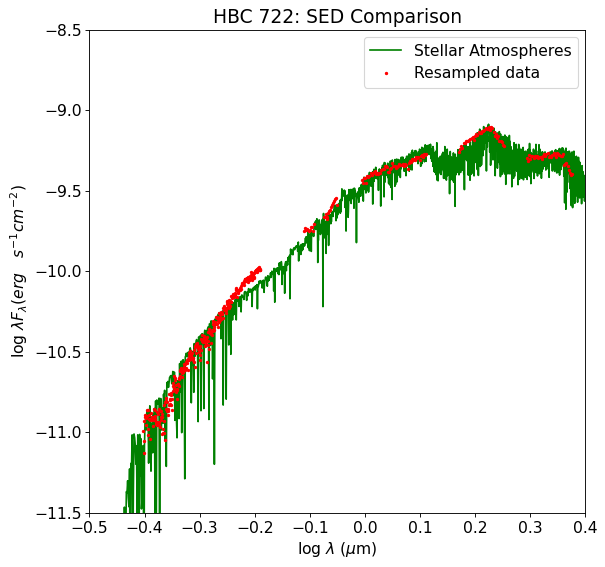

In [589]:
fig=plt.figure(figsize=(8, 8), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(x_atm, y_atm, \
         'g-', label='Stellar Atmospheres')
# plt.plot(np.log10(x_data*1e-4), np.log10(y_data*x_data), '-', label='Full data points')
plt.plot(x1,y1, 'ro', markersize=2, label='Resampled data')
plt.plot(x2,y2, 'ro', markersize=2)
plt.plot(x3,y3, 'ro', markersize=2)
# plt.plot(x4,y4, 'ro', markersize=2)



plt.plot(x1I,y1I, 'ro', markersize=2)
plt.plot(x2I,y2I, 'ro', markersize=2)
plt.plot(x3I,y3I, 'ro', markersize=2)
# plt.plot(x4I,y4I, 'ro', markersize=2)
# plt.plot(xI,yI, 'ro', markersize=2)




plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('HBC 722: SED Comparison')
plt.ylim(-11.5, -8.5)
plt.xlim(-0.5, 0.4)
plt.legend()
plt.show()

In [596]:
# WAV_OUT = np.concatenate((x1, x2, x3, xI))
WAV_OUT = np.concatenate((x1, x2, x3, x1I, x2I, x3I))

In [599]:
# FLUX_OUT = np.concatenate((y1,y2, y3, yI))
FLUX_OUT = np.concatenate((y1, y2, y3, y1I, y2I, y3I))

In [600]:
import csv
with open('hbc_out_new_calib_NEW_NIR.csv', 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(zip(WAV_OUT, FLUX_OUT))